In [2]:
import numpy as np
import pandas as pd
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.base import clone
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv("dataset/kaggle/cardio_train.csv", delimiter=';', index_col=0)
df.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,
0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [4]:

# Split into a "World" pool (Attacker has some data, Hospital has some)
# Target Data: The exact rows used to train the Victim Model
# Population Data: Other rows from the same distribution (used for shadow models)
X_train_target, X_population, y_train_target, y_population = train_test_split(
    df.drop('cardio', axis=1), df['cardio'], test_size=0.66, random_state=42
)
X_population, X_holdout, y_population, y_holdout = train_test_split(
    X_population, y_population, test_size=0.3, random_state=42
)
print(f"Target Train Size: {X_train_target.shape[0]}")
print(f"Population Size: {X_population.shape[0]}")
print(f"Holdout Size: {X_holdout.shape[0]}")

Target Train Size: 23800
Population Size: 32340
Holdout Size: 13860


In [9]:

# ==========================================
# 2. TRAIN TARGET MODEL (The Victim)
# ==========================================
# Using Random Forest as it is common in tabular healthcare data
from xgboost import XGBClassifier
from sklearn.svm import SVC

target_model = XGBClassifier(
    n_estimators=100,
    max_depth=10,
    learning_rate=0.5,
    min_child_weight=1,
    subsample = 1.0,
    eval_metric='logloss',
    random_state=42)
target_model.fit(X_train_target, y_train_target)

print(f"Target Model Accuracy: {target_model.score(X_train_target, y_train_target):.2f}")
print(f"Test Model Accuracy: {target_model.score(X_holdout, y_holdout):.2f}")

Target Model Accuracy: 0.96
Test Model Accuracy: 0.69


In [ ]:
    def _logit_scale(self, probs):
        """Transform probabilities to logit space with numerical stability."""
        epsilon = 1e-5
        probs = np.clip(probs, epsilon, 1 - epsilon)
        return np.log(probs / (1 - probs))

In [24]:

# ==========================================
# 3. LiRA IMPLEMENTATION
# ==========================================

class LiRAAttack:
    """Offline LiRA attack implementation for tabular data."""

    def __init__(
        self,
        target_model,
        n_shadow_models=16,
    ):
        self.target_model = target_model
        self.n_shadow_models = n_shadow_models

        self.shadow_models = []
        self.shadow_data_indices = []  # Track which rows were used in which model
        # Storage for the extracted signals
        self.target_scores = None  # Shape: (n_samples,)
        self.shadow_scores = None  # Shape: (n_samples, n_shadow_models)
    
    def _get_true_class_log_prob(self, model, X, y):
        """
        Helper method: Extracts the probability of the true class 
        and converts it to Logit space (Logit Scaling).
        
        Math: Logit(p) = log(p / (1 - p))
        """
        # 1. Get raw probabilities: Shape (N, n_classes)
        # XGBoost and sklearn both support predict_proba
        probs = model.predict_proba(X)
        
        # 2. Extract the probability of the TRUE class 'y'
        true_class_probs = probs[np.arange(len(X)), y]
        
        # 3. NUMERICAL STABILITY (Crucial Step)
        # We must clip probabilities to avoid log(0) or divide-by-zero.
        # We clip to [epsilon, 1-epsilon]
        epsilon = 1e-6
        true_class_probs = np.clip(true_class_probs, epsilon, 1 - epsilon)
        
        # 4. Apply Logit Scaling (Inverse Sigmoid)
        # This maps [0, 1] -> (-inf, +inf)
        logits = np.log(true_class_probs / (1 - true_class_probs))
        
        return logits

    def train_shadow_models(self, X_pool, y_pool):
        """Train shadow models and build reference IN/OUT distributions."""
        print(f"Training {self.n_shadow_models} Shadow Models...")

        # Reset caches every time we train
        self.shadow_models = []
        self.shadow_data_indices = []

        for i in range(self.n_shadow_models):
            shadow_model = clone(self.target_model)
            shadow_model.fit(X_pool, y_pool)
            self.shadow_models.append(shadow_model)

            if i % 5 == 0 or i == self.n_shadow_models - 1:
                print(f"  - Trained {i+1}/{self.n_shadow_models} shadow models.")

    def extract_signals(self, X, y):
        """
        Phase 4: Signal Extraction
        Populates self.target_scores and self.shadow_scores
        """
        print(f"Extracting signals for {len(X)} samples...")

        # --- Step A: Get Target Model Scores ---
        # These are the 'observed' values we want to test
        self.target_scores = self._get_true_class_log_prob(self.target_model, X, y)
        
        # --- Step B: Get Shadow Model Scores ---
        # These form the 'reference distribution'
        shadow_matrix = []
        
        for i, sm_model in enumerate(self.shadow_models):
            # Get scores for the SAME X, y from the perspective of the shadow model
            sm_scores = self._get_true_class_log_prob(sm_model, X, y)
            shadow_matrix.append(sm_scores)
            
        # Transpose so rows = samples, columns = shadow models
        # Final Shape: (n_samples, n_shadow_models)
        self.shadow_scores = np.array(shadow_matrix).T
        
        print(f"Signal Extraction Complete.")
        print(f"Target Scores Shape: {self.target_scores.shape}")
        print(f"Shadow Scores Shape: {self.shadow_scores.shape}")
        
        # For chaining method calls
        return self
    
    def fit_calibration(self):
        """
        Phase 5: Calibration (Fitting the Gaussian)
        
        Calculates the Mean (mu) and Standard Deviation (sigma) 
        of the shadow scores for each sample.
        
        Assumption: Non-member scores follow a Gaussian distribution.
        """
        print("Calibrating shadow distributions...")
        
        if self.shadow_scores is None:
            raise ValueError("Run extract_signals() first!")

        # Calculate stats across the shadow models (axis=1)
        # Result Shape: (n_samples,)
        self.mean_scores = np.mean(self.shadow_scores, axis=1)
        self.std_scores = np.std(self.shadow_scores, axis=1)
        
        # --- Stability Trick ---
        # Add a tiny epsilon to sigma to prevent division by zero 
        # during the Z-score calculation later.
        epsilon = 1e-10
        self.std_scores = self.std_scores + epsilon
        
        print(f"Calibration Complete.")
        print(f"Computed means for {len(self.mean_scores)} samples.")
        
        return self

    def calculate_lira_scores(self):
        """
        Phase 6: The Attack (Z-Score Calculation)
        
        Computes the likelihood ratio (approximated as Z-score).
        High score = High likelihood of being a member.
        """
        if self.mean_scores is None:
            raise ValueError("Run fit_calibration() first!")
            
        # Vectorized Z-Score Formula:
        # (Target - Mean_out) / Std_out
        self.lira_scores = (self.target_scores - self.mean_scores) / self.std_scores
        
        return self.lira_scores

In [25]:

# ==========================================
# 4. EXECUTE ATTACK
# ==========================================

# Initialize Attack
attacker = LiRAAttack(target_model, n_shadow_models=32)

# Train Shadow Models (using the Population data the attacker has)
attacker.train_shadow_models(X_population, y_population)
# Calculate LiRA Scores on Holdout Set
attacker.extract_signals(X_holdout, y_holdout)
attacker.fit_calibration()
lira_scores_holdout = attacker.calculate_lira_scores()

Training 32 Shadow Models...
  - Trained 1/32 shadow models.
  - Trained 6/32 shadow models.
  - Trained 11/32 shadow models.
  - Trained 16/32 shadow models.
  - Trained 21/32 shadow models.
  - Trained 26/32 shadow models.
  - Trained 31/32 shadow models.
  - Trained 32/32 shadow models.
Extracting signals for 13860 samples...
Signal Extraction Complete.
Target Scores Shape: (13860,)
Shadow Scores Shape: (13860, 32)
Calibrating shadow distributions...
Calibration Complete.
Computed means for 13860 samples.


In [26]:
# Calculate LiRA Scores on Target Set
attacker.extract_signals(X_train_target, y_train_target)
attacker.fit_calibration()
lira_scores_train = attacker.calculate_lira_scores()

Extracting signals for 23800 samples...
Signal Extraction Complete.
Target Scores Shape: (23800,)
Shadow Scores Shape: (23800, 32)
Calibrating shadow distributions...
Calibration Complete.
Computed means for 23800 samples.


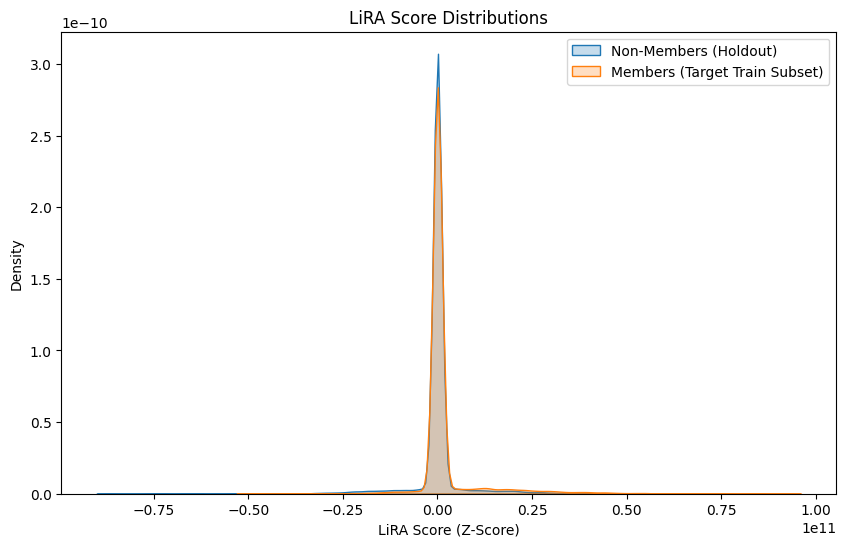

In [29]:
from matplotlib import pyplot as plt

# Plot the distribution of LiRA scores for Members vs Non-Members
plt.figure(figsize=(10, 6))
sns.kdeplot(lira_scores_holdout, label='Non-Members (Holdout)', fill=True)
sns.kdeplot(lira_scores_train,label='Members (Target Train Subset)',fill=True)
plt.title("LiRA Score Distributions")
plt.xlabel("LiRA Score (Z-Score)")
plt.ylabel("Density")
plt.legend()
plt.show()

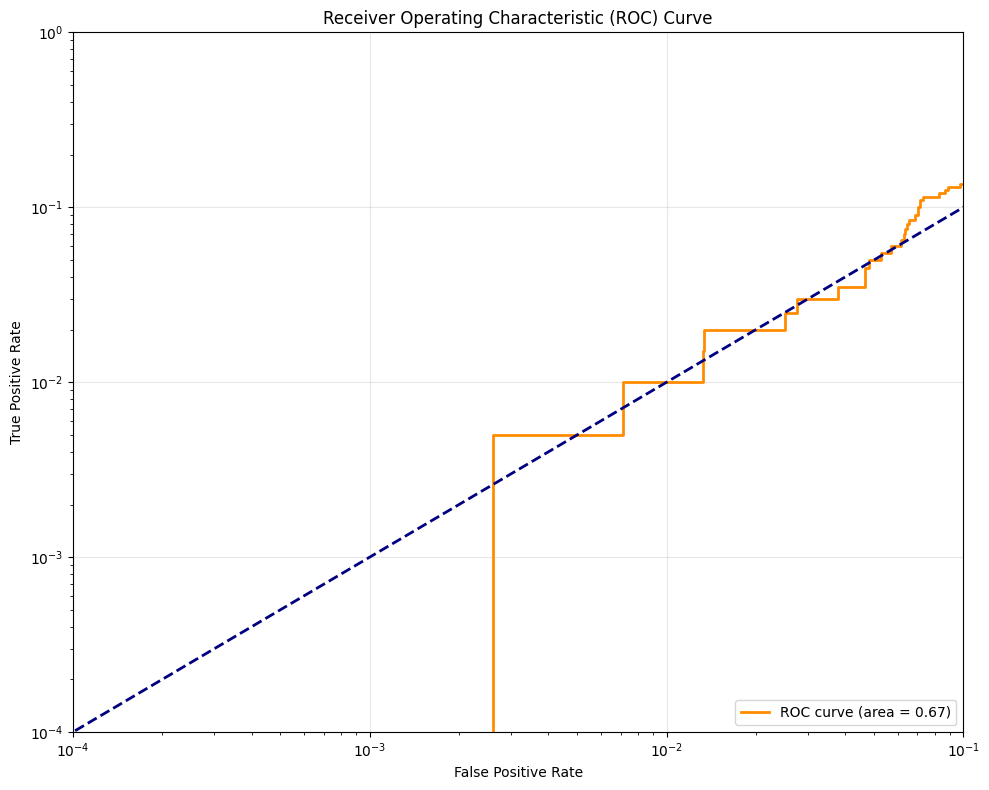

LiRA Attack AUC: 0.67


In [ ]:

# ROC Curve
labels = np.concatenate([np.ones(len(member_scores)), np.zeros(len(non_member_scores))])
scores = np.concatenate([member_scores, non_member_scores])

# Plot the ROC curve
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(labels, scores)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([1e-4, 0.1])
plt.ylim([1e-4, 1.0])
plt.yscale('log')
plt.xscale('log')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
print(f"LiRA Attack AUC: {roc_auc:.2f}")